<a name="Inicio"></a>
# Data Analysis

#### Autor: *Ángel Pérez Lemonche*


## Descripción general

Este script utiliza las matrices de transición generadas en "Learning Paths with General *bricks*" con el fin de analizar el contenido de los datos para tomar futuras decisiones. Se puede realizar el mismo proceso utilizando **vectores de frecuencias**, normalizando por el número total de transiciones por semanas.

### Importación de librerías y declaración de funciones

In [23]:
# Librerías generales
import numpy as np
import pandas as pd
import time

import sys
sys.path.insert(0, './lib/')

import imp
import myfunclib as mf
import auxiliares as ax
import transiciones as tr
import myValFunctions as vf
import myClusteringFunctions as cf


# Librerías propias
mf = imp.reload(mf)
ax = imp.reload(ax)
tr = imp.reload(tr)

vf = imp.reload(vf)
cf = imp.reload(cf)


pd.set_option('display.max_columns', 30)
from IPython.core.display import display, HTML, clear_output

# Librerías ML
from sklearn.cluster import KMeans

# Gráficos
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import style
#style.use("ggplot")
plt.rcParams["figure.figsize"] = [5,5]

Cargamos el fichero de entrada

In [2]:
# Diccionario semana

from datetime import datetime

### EDICION 1 ##

sem1 = datetime(2015,2,24)
sem2 = datetime(2015,3,3)
sem3 = datetime(2015,3,10)
sem4 = datetime(2015,3,17)
sem5 = datetime(2015,3,24)
sem6 = datetime(2015,3,31)
sem7 = datetime(2015,4,7)
sem8 = datetime(2015,4,14)

"""
###EDICION 2 ##

sem1 = datetime(2015,10,5)
sem2 = datetime(2015,10,12)
sem3 = datetime(2015,10,19)
sem4 = datetime(2015,10,26)
sem5 = datetime(2015,11,2)
sem6 = datetime(2015,11,9)
sem7 = datetime(2015,11,16)
sem8 = datetime(2015,11,23)
"""

SEM = {"Week1": [sem1, sem2],
       "Week2": [sem2, sem3],
       "Week3": [sem3, sem4],
       "Week4": [sem4, sem5],
       "Week5": [sem5, sem6],
       "Week6": [sem6, sem7]}

In [3]:
# Cargamos el fichero de trabajo
filename = "files/eventos_final.json"

eventsDFRaw = ax.readDataFile(filename)
eventsDFRawT = eventsDFRaw[eventsDFRaw['Usuario'] != '']
print("Tamaño:",len(eventsDFRaw))
print(eventsDFRaw.head(10))


Tamaño: 7171
                                             Eventos  Usuario
0  [{'evento': 'play_video', 'tiempo': '2015-02-2...         
1  [{'evento': 'load_video', 'tiempo': '2015-02-2...  6139738
2  [{'evento': 'load_video', 'tiempo': '2015-02-2...  6445710
3  [{'id_documento': '2.1. La primera interfaz de...  6594737
4  [{'evento': 'load_video', 'tiempo': '2015-02-2...  6451715
5  [{'evento': 'load_video', 'tiempo': '2015-02-2...  4594216
6  [{'id_documento': '1.1. El entorno de desarrol...  2507090
7  [{'evento': 'load_video', 'tiempo': '2015-02-2...  5619682
8  [{'evento': 'load_video', 'tiempo': '2015-03-2...  6757226
9  [{'evento': 'load_video', 'tiempo': '2015-03-1...  6695320


In [4]:
eventsDF = eventsDFRawT

In [5]:
'''# Filtrado por usuario: eliminamos los que hayan realizado
#  menos de 50 eventos en el curso
minEvents = 50

eventsDF = ax.dataFiltering(eventsDFRaw, minEvents);
print("Tamaño:",len(eventsDF))   
print(eventsDF.head(10))'''

'# Filtrado por usuario: eliminamos los que hayan realizado\n#  menos de 50 eventos en el curso\nminEvents = 50\n\neventsDF = ax.dataFiltering(eventsDFRaw, minEvents);\nprint("Tamaño:",len(eventsDF))   \nprint(eventsDF.head(10))'

In [42]:
# Transiciones x semana
dicEvents = {
    'V' : ['play_video', 'seek_video'],
    'N' : ['problem_check'],
    'F' : ['edx.forum.searched', 'edx.forum.comment.created', 
           'edx.forum.response.created', 'edx.forum.thread.created'],
    'P' : ['openassessmentblock.self_assess'],
    'D' : ['textbook.pdf.chapter.navigated']
}

param = {'dicEvents': dicEvents,
        'assignationProblemCheckFile': 'IDNaturalProblemasEd1.csv',
        'ProblemCheckExceptions': ['J','X'],
        'useFreq': False}


startTotal = time.time()
transitionsDF = tr.Transitions(eventsDF, param)
print("%.2f"%((time.time() - startTotal)/60), 'minutos.')

4.65 minutos.


In [43]:
transitionsDF.set_index('Usuario', inplace = True)

In [ ]:
#transitionsDF.to_csv('Transitionsdf.csv')

In [44]:
transitionsDF2 = transitionsDF[:][(transitionsDF.sum(axis=1) > 20)]
if True:
    transitionsDF2 = transitionsDF2.div(transitionsDF2.sum(axis=1), axis=0)
    transitionsDF2 = transitionsDF2.fillna(0.)

len(transitionsDF2)

2505

Reducción de dimensionalidad

In [45]:
# Selección de características

def MinMaxNorm(series):
    minim = series.min()
    maxim = series.max()
    return (series-minim)/(maxim-minim)

def ZNorm(series):
    mean = series.mean()
    std = series.std()
    return (series-mean)/std

def featFrequency(featuresDF, info = .95, Normalize = None, Use_Rest = True, verbose = 1):
    import pandas as pd
    featDF = featuresDF.copy()
    returnDF = featuresDF.copy()

    if Normalize != None:
        featDF = featDF.apply(lambda x: Normalize(x), axis=0)
    
    suma = featDF.sum(axis=0)
    perinfo = (abs(suma)/abs(suma).sum()).sort_values(ascending=False)
    cumsum = perinfo.cumsum()

    featInfo = pd.concat([perinfo, cumsum], axis = 1)
    featInfo.columns = ['percentage', 'cumsum']
    featInfo['selection'] = (featInfo['cumsum'] < info)

    returnDF = returnDF[featInfo.index[featInfo.selection]]

    if Use_Rest:
        returnDF['Rest'] = featuresDF[featInfo.index[featInfo.selection == False]].sum(axis=1)
    
    if verbose > 0:
        print('From',len(featuresDF.columns),'to',len(returnDF.columns), 'selected features.')
        if verbose == 2:
            pd.options.display.float_format = '{:,.2f}%'.format
            toPrint = featInfo[['percentage','cumsum']].apply(lambda x: x*100)
            toPrint['selection'] = featInfo.selection
            display(toPrint)
    
    return returnDF, list(featInfo.index[featInfo.selection])

In [56]:
featuresDF, _ = featFrequency(transitionsDF2, info = .95, verbose = 2)

From 36 to 11 selected features.


,percentage,cumsum,selection
D->D,19.92%,19.92%,True
E->E,17.33%,37.25%,True
A->A,17.05%,54.30%,True
V->E,12.30%,66.60%,True
V->V,11.76%,78.36%,True
E->V,10.98%,89.34%,True
D->V,1.83%,91.17%,True
V->D,1.20%,92.37%,True
A->V,1.12%,93.49%,True
E->A,1.03%,94.52%,True


### Validación

In [53]:
nClusters = 10
seed = 206
nRepetitions = 1000
computeClusterValidation = True
plt.rcParams["figure.figsize"] = [5,3]

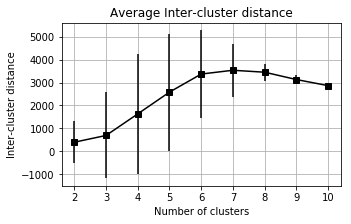

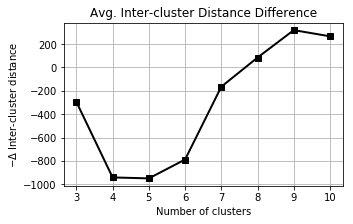

In [54]:
if computeClusterValidation:
    av, st = vf.interClusterDistKMeans(featuresDF, nClusters = nClusters, nRandomStates = nRepetitions, 
                                    seed = seed, plot = True)

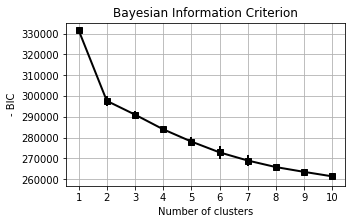

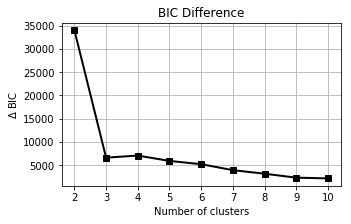

In [55]:
if computeClusterValidation:
    av, st = vf.BICCriterionKMeans(featuresDF, nClusters = nClusters, nRandomStates = nRepetitions, 
                                    seed = seed, plot = True)

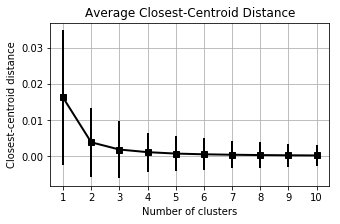

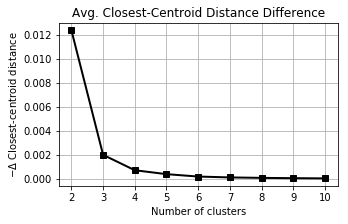

In [50]:
if computeClusterValidation:
    av, st = vf.closestCentroidDistKMeans(featuresDF, nClusters = nClusters, nInit = nRepetitions, 
                                    seed = seed, plot = True)

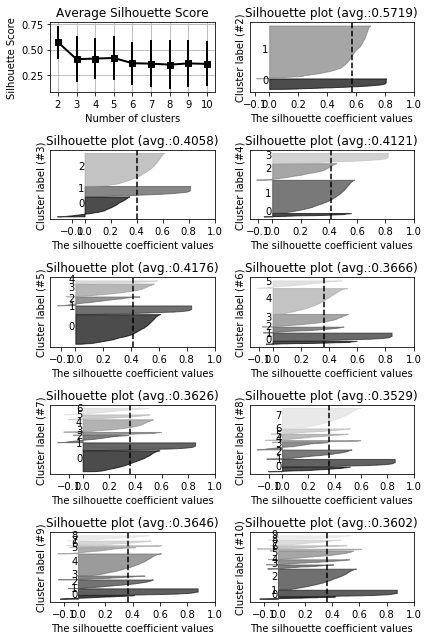

In [51]:
if computeClusterValidation:
    plt.figure(figsize=(6,9))
    av, st = vf.silhouetteKMeans(featuresDF, nClusters = nClusters, nInit = nRepetitions, 
                                    seed = seed, plot = True)

In [60]:
# EVALUATE THE PARAMETERS OF THE MODEL

from sklearn.cluster import KMeans
model = KMeans()

param_grid = {
    'n_clusters' : [5],
    'algorithm' : ['auto', 'full'],
    'init' : ['k-means++', 'random'],
    'n_init' : [20],
    'max_iter' : [200, 300],
    'random_state' : [None]
}

In [61]:
ParametersEvaluation = True

if ParametersEvaluation:
    nkFolds = 50
    scores, parameters, _ = vf.DeepCrossValidationClustering(featuresDF, 'KMeans', model, param_grid, kfold=nkFolds)

    print('\nEVALUATION\n')

    vf.evaluateResults(scores, parameters)

KMeans_01 - Tiempo de proceso [s]: 39.731
KMeans(algorithm='auto', copy_x=True, init='random', max_iter=200,
    n_clusters=5, n_init=20, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Puntuación de entrenamiento: -100.232961879
Puntuación de validación: -2.02052313944
Puntuación de test: -1.88984567684


KMeans_02 - Tiempo de proceso [s]: 41.476
KMeans(algorithm='auto', copy_x=True, init='random', max_iter=200,
    n_clusters=5, n_init=20, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Puntuación de entrenamiento: -100.557626174
Puntuación de validación: -2.0242750798
Puntuación de test: -1.56172849388


KMeans_03 - Tiempo de proceso [s]: 41.064
KMeans(algorithm='full', copy_x=True, init='random', max_iter=300,
    n_clusters=5, n_init=20, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Puntuación de entrenamiento: -99.6379461923
Puntuación de validación: -2.00545112494


KMeans_25 - Tiempo de proceso [s]: 42.837
KMeans(algorithm='auto', copy_x=True, init='random', max_iter=200,
    n_clusters=5, n_init=20, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Puntuación de entrenamiento: -99.9339454854
Puntuación de validación: -2.0119149031
Puntuación de test: -2.18587510844


KMeans_26 - Tiempo de proceso [s]: 41.064
KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=5, n_init=20, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Puntuación de entrenamiento: -99.089874796
Puntuación de validación: -1.99496671648
Puntuación de test: -3.03107047616


KMeans_27 - Tiempo de proceso [s]: 38.494
KMeans(algorithm='auto', copy_x=True, init='random', max_iter=200,
    n_clusters=5, n_init=20, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Puntuación de entrenamiento: -100.527747928
Puntuación de validación: -2.02486221378
P

KMeans_49 - Tiempo de proceso [s]: 42.077
KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=5, n_init=20, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Puntuación de entrenamiento: -99.1767461881
Puntuación de validación: -1.99540401936
Puntuación de test: -2.94618536969


KMeans_50 - Tiempo de proceso [s]: 43.682
KMeans(algorithm='full', copy_x=True, init='random', max_iter=300,
    n_clusters=5, n_init=20, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Puntuación de entrenamiento: -100.45140413
Puntuación de validación: -2.02113426601
Puntuación de test: -1.66490431135



EVALUATION

Train Score:	 -100.066 +- 0.389
CrossVal Score:	 -2.014 +- 0.008
Test Score:	 -2.056 +- 0.390


['0.28'] ["{'algorithm': 'auto', 'copy_x': True, 'init': 'random', 'max_iter': 300, 'n_clusters': 5, 'n_init': 20, 'n_jobs': 1, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 've

In [62]:
nInitializations = 500
nPartitions = 500
test_size = .20

model.set_params(n_clusters = 5, algorithm = 'auto', init = 'random', max_iter = 300, n_init = 20)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=5, n_init=20, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  3.9min
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  6.7min
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  8.9min
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed: 11.2min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 13.9min
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed: 16.5min
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed: 20.0min
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed: 23.6min
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed: 27.1min
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed: 30.8min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 34.6min
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed: 39.2min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 43.6min
[Parallel(n_jobs=8)]: Done 205 tasks      | elapsed: 48.3min
[Parallel(n_jobs=8)]: Do

Error Difference: -66.4347806001
Validation: -17.899932874
Seed: [2286, 1566]


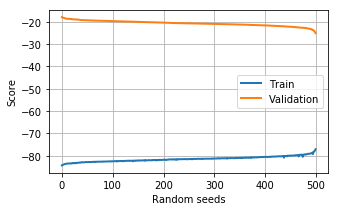

In [63]:
model = model.set_params(n_clusters = 5)

model, bestSeed, results = vf.InitializationSeed(featuresDF, model, test_size = test_size, seed = seed,
                                nRandomStates = nInitializations, CrossVal = nPartitions)
print('Seed:', bestSeed)

In [64]:
model = vf.CreatePartitionAndFitSelectedModel(featuresDF, model, test_size, bestSeed[0], bestSeed[1])
labels = model.predict(featuresDF)
centers = model.cluster_centers_

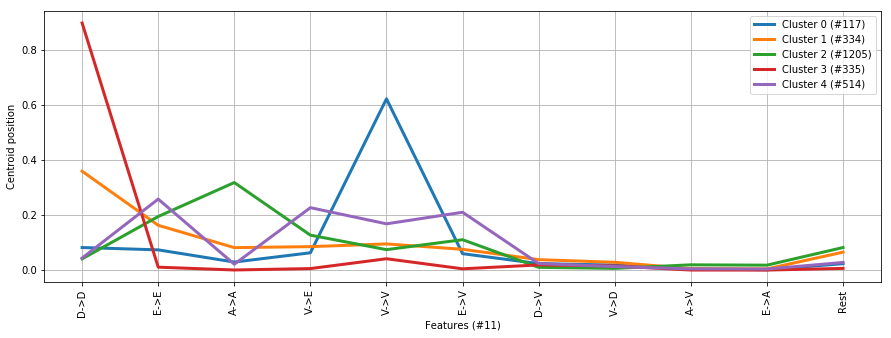

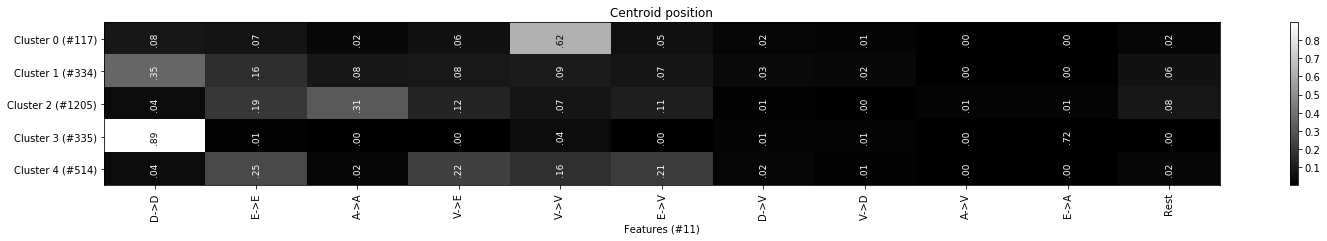

In [65]:
cf.plotCentroids(centers, labels, featuresDF.columns, sort = [], avg = False, matrix = True, textThreshold = -.01)

In [66]:
alpha = 10**-1

In [68]:
DP, DC = vf.checkClusterPositions(featuresDF, model, test_size, results, alpha)
_ =[print("%d%%"%(x[0]*100),x[1],x[2],'\n') for x in DP if (x[0]*100)>2]

DC

90% [['E->E', 'A->A', 'A->V', 'E->A', 'Rest'], ['V->V'], ['D->D'], ['D->D', 'D->V', 'V->D', 'Rest'], ['E->E', 'V->E', 'V->V', 'E->V']] [990, 1100] 

8% [['V->V'], ['D->D', 'D->V', 'V->D'], ['E->E', 'A->A', 'A->V', 'E->A', 'Rest'], ['D->D'], ['E->E', 'V->E', 'V->V', 'E->V']] [2286, 1566] 



[("['V->V']", 0.3115054037954217),
 ("['D->D', 'D->V', 'V->D', 'Rest']", 0.2829546421581142),
 ("['E->E', 'A->A', 'A->V', 'E->A', 'Rest']", 0.19074972342779337),
 ("['D->D']", 0.12743596289677475),
 ("['E->E', 'V->E', 'V->V', 'E->V']", 0.06373925623351204),
 ("['D->D', 'D->V', 'V->D']", 0.0230193175048932),
 ("['A->A', 'A->V', 'E->A', 'Rest']", 0.0005956939834907667)]